In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from os.path import join as pjoin
import scipy
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
from tvb.simulator.lab import *

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# for test
file = pjoin('/Users/yilewang/Documents/K21_explore', 'AD', "0306A_0.1.csv")
raw_sim_fmri = pd.read_csv(file,header=0)
s_corr = raw_sim_fmri.corr()

### Workflow

In [3]:
data_dir = '/Users/yilewang/workspaces/data4project/'
ts_dir = pjoin(data_dir, 'lateralization/ts_fmri/fmri_AAL_16/')
connectome_dir = pjoin(data_dir, 'lateralization/connectome/zip')
# read mega_table
mega_table = pd.read_excel(pjoin(data_dir, 'mega_table.xlsx'), sheet_name='hodgepodge', skiprows=1)

In [4]:
def tvb_K21_fitting(k21, Go, file):
    connectivity.speed = np.array([10.])
    sim = simulator.Simulator(
        model=ReducedSetHindmarshRose(K21=np.array([k21])), 
        connectivity=connectivity.Connectivity.from_file(file),                      
        coupling=coupling.Linear(a=np.array([Go])),
        simulation_length=1e3*416,
        integrator=integrators.HeunStochastic(dt=0.01220703125, noise=noise.Additive(nsig=np.array([1.0]), ntau=0.0,
                                                                                    random_stream=np.random.RandomState(seed=42))),
        monitors=(
        monitors.TemporalAverage(period=1.),
        monitors.Bold(hrf_kernel = equations.Gamma(), period=2000.),
        monitors.ProgressLogger(period=1e2)
        ))
    sim.configure()
    (tavg_time, tavg_data), (raw_time, raw_data),_ = sim.run()
    return raw_data

In [27]:
K21_range = np.arange(0.1, 3.1, 0.1)
_K21_range = [str(round(i, 1)) for i in K21_range]
# create a dataframe to store the correlation by each K21
corr_df = pd.DataFrame()

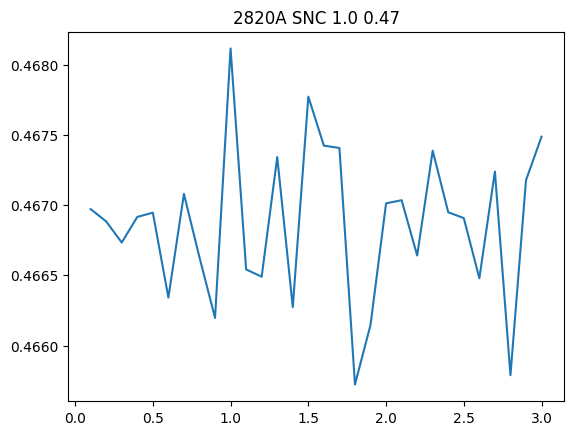

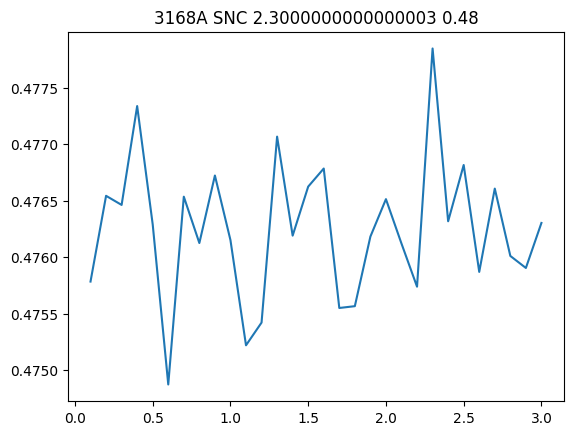

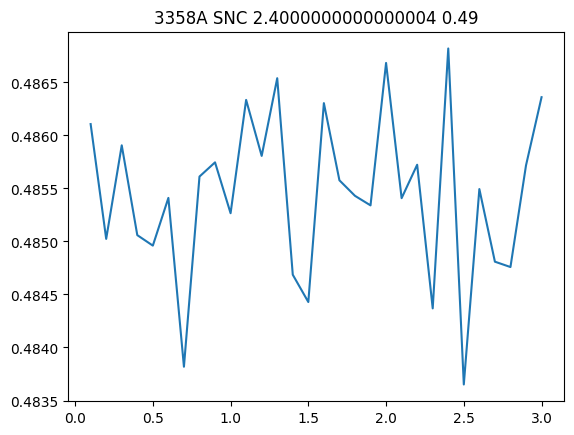

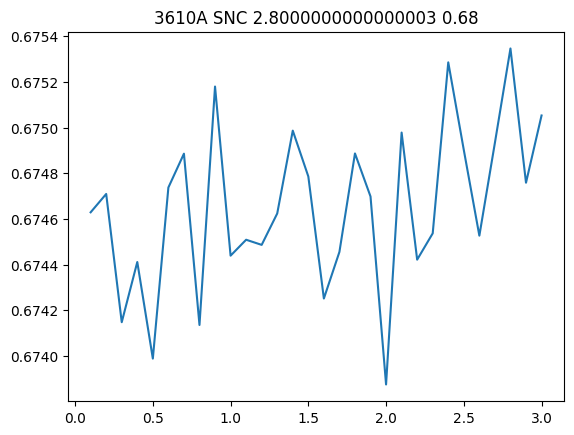

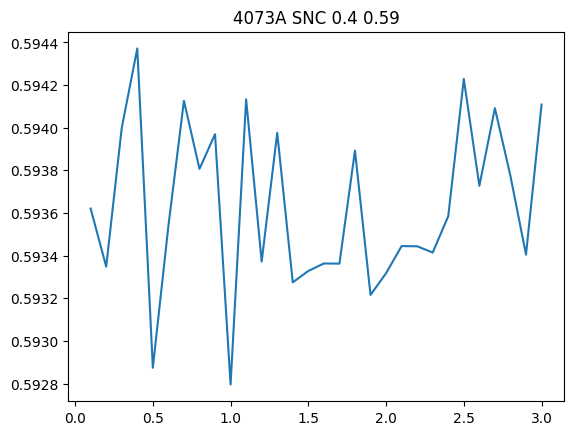

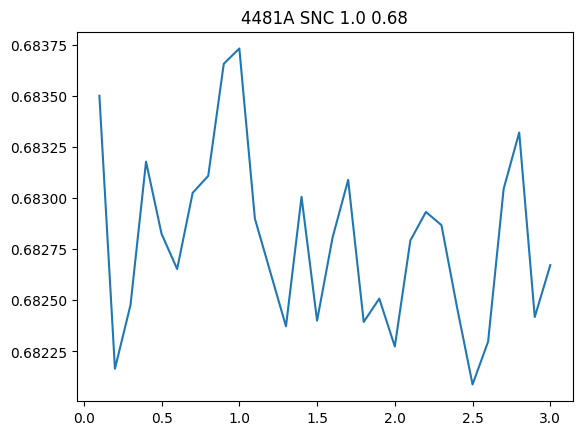

2024-04-23 17:11:33,031 - WARNING - tvb.basic.readers - File 'average_orientations' not found in ZIP.
2024-04-23 17:11:33,032 - WARNING - tvb.basic.readers - File 'cortical' not found in ZIP.
2024-04-23 17:11:33,032 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2024-04-23 17:11:33,033 - WARNING - tvb.basic.readers - File 'areas' not found in ZIP.
2024-04-23 17:11:33,046 - INFO - tvb.simulator.monitors - step 1 time 0.0000 s
2024-04-23 17:11:34,182 - INFO - tvb.simulator.monitors - step 8193 time 0.1000 s
2024-04-23 17:11:35,339 - INFO - tvb.simulator.monitors - step 16385 time 0.2000 s
2024-04-23 17:11:36,455 - INFO - tvb.simulator.monitors - step 24577 time 0.3000 s
2024-04-23 17:11:37,623 - INFO - tvb.simulator.monitors - step 32769 time 0.4000 s
2024-04-23 17:11:38,772 - INFO - tvb.simulator.monitors - step 40961 time 0.5000 s
2024-04-23 17:11:39,885 - INFO - tvb.simulator.monitors - step 49153 time 0.6000 s
2024-04-23 17:11:41,001 - INFO - tvb.simulator.monit

KeyboardInterrupt: 

In [29]:
for case, grp, go in zip(mega_table['caseid'], mega_table['group'], mega_table['Go']):
    K21_corr = []
    
    for K21 in K21_range:
        K21 = np.round(K21, 1)
        file = pjoin('/Users/yilewang/Documents/K21_explore', grp, f"{case}_{format(K21, '.1f')}.csv")
        try:
            raw_sim_fmri = pd.read_csv(file, header=0)
        except:
            raw_data = tvb_K21_fitting(K21, go, pjoin(connectome_dir, grp, case +'.zip'))
            raw_data_mean = np.mean(raw_data, axis=3)
            raw_sim_fmri = pd.DataFrame(raw_data_mean[:,0,:], columns = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R'])
        s_corr = raw_sim_fmri.corr()
        # read mat file
        mat = scipy.io.loadmat(pjoin(ts_dir, grp+"-TS", case, f"ROISignals_{case}.mat"))
        roi_signal = mat['ROISignals']
        df_roi = pd.DataFrame(roi_signal, columns = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R'])
        e_corr = df_roi.corr()

        # take the top triangle of the matrix using triu
        e_corr = np.triu(e_corr, k=1)
        s_corr = np.triu(s_corr, k=1)

        # calculate the correlation of the two matrices
        s_corr = s_corr.flatten()
        e_corr = e_corr.flatten()
        # pearson correlation of two flattened matrices
        corr_pearson = np.corrcoef(s_corr, e_corr)[0,1]
        K21_corr.append(corr_pearson)
    single_pd = pd.DataFrame([K21_corr], columns=_K21_range)
    single_pd['case'] = case
    single_pd['group'] = grp
    corr_df = pd.concat([corr_df, single_pd], axis=0)

    plt.plot(K21_range, K21_corr)
    plt.title(f"{case} {grp} {K21_range[np.argmax(K21_corr)]} {np.round(K21_corr[np.argmax(K21_corr)],2)}")
    plt.show()